# Notes from *Lesson 1*
Youtube video: [Practical Deep Learning for Coders: Lesson 1](https://www.youtube.com/watch?v=8SF_h3xF3cE)

I will follow along with the video, make notes and copy code etc.

## Contents
- Imports
- Defining functions and model 1: Honda Jazz vs F1 Car
- Model 2: House vs Tractor
- Model 3: Cat vs Dog vs LLama

## Imports

In [69]:
# some notes on keyboard shortcuts
 
'''
- mac shortcuts
    option + arrow_key_left -> move left one word
    option + arrow_key_right -> move right one word
    command + arrow_key_left -> move to start of first word on line
    command + arrow_key_right -> move to end of last word on line
    fn + backspace -> delete
- vscode shortcuts
    when a cell is selected:
        control + enter -> execute current cell
        shift + enter -> execute current cell and select cell below
        option + enter -> execute current cell, inset new cell below and select new cell below
        control + shift + '-' -> split current cell at the curse
    when a cell is not selected:
        a -> insert code cell above current cell
        b -> insert code cell below current cell
        m -> make the cell a markdown cell
        y -> make the cell a code cell
        d, d -> delete the currently selected cell
        z -> undo the last cell operation
    general vscode shortcuts:
        command + s -> save the current file
        command + z -> undo the last action
        command + shift + z -> redo the last undone action
        command + shift + p -> open the command palette
        command  + b -> toggle the sidebar visibility
        control + '`' -> toggle the integrated terminal
- Conda environment
    install conda and set up an environment to work in
    terminal commands:
        'conda activate [ENV]' -> activate pre established environment
        'conda install [PACKAGE]' -> install package to environment from the default channel (maintained by Anaconda)
        'conda config --show channels' -> show a list of the configured channels
        'conda install -c conda-forge [PACKAGE]' -> install package to envirnment from conda-forge channel (-c flag specified the channel you want to use)
- setting up Jupyter notebook
- git
    terminal commands:
        'git config --global user.name "[GITHUB USERNAME]"' -> set the username for the global configuration
        'git confit --global user.email "ID+username@users.noreply.github.com"' -> set email for global configuration to pseudonymized email
        'git commit --amend --reset-author' -> fix the identity of whoever made a commit
        'git push --set-upstream origin [BRANCH]' -> push commits to remote repository and set remote branch as default tracking branch
''';

In [183]:
# use dir() to determine how many classes, functions and "other" objects are imported using the fastbook wildcard import

before_dir = dir()

from fastbook import *
import fastbook
import numpy as np

after_dir = dir()
print(f'number of imported functions and classes: {len(after_dir) - len(before_dir)}')
print(f'(this only works the first time this cell is ran)')
print('-----')

def categorize_items(module):
    functions, classes, other = set(), set(), set()
    for item in dir(module):
        attribute = getattr(module, item)
        if inspect.isfunction(attribute):
            functions.add(item)
        elif inspect.isclass(attribute):
            classes.add(item)
        else:
            other.add(item)
    return functions, classes, other

functions, classes, other = categorize_items(fastbook)

print(f'Number of functions imported with fastbook: {len(functions)}')
print(f'Number of classes imported with fastbook: {len(classes)}')
print(f'Number of "other" objects imported with fastbook: {len(other)}')
print(f'Total number of attributes imported with fastbook: {len(functions) + len(classes) + len(other)}')

number of imported functions and classes: 0
(this only works the first time this cell is ran)
-----
Number of functions imported with fastbook: 638
Number of classes imported with fastbook: 429
Number of "other" objects imported with fastbook: 137
Total number of attributes imported with fastbook: 1204


## Defining Functions and Model 1: Honda Jazz vs F1 Car

Note: When downloading individual images to test the download function, the folder can get messy with random .jpg images. All .jpg images in the folder can be deleted using the following terminal command:

`find . -maxdepth 1 -type f -name "*.jpg" -delete`

In [229]:
# delete all the files with specified extensions in the cwd and sub-directories (if specified with maxdepth argument)
def delete_images(extensions, depth):
    for ext in extensions:
        command = f'find . -maxdepth {depth} -type f -name "{ext}" -delete'
        os.system(command)

extensions = [
    '*.jpg',
    '*.JPG',
    '*.jpeg',
    '*.png',
    '*.webp',
    '*.jpg!d',
    '*.ashx',
    '*.gif']

delete_images(extensions, depth=1)


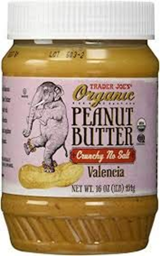

In [170]:
# download a single image from duckduckgo
def download_single(term, show_image=True):
    """
    Download a single image based on a search term and optionally display it.

    This function searches for an image using the specified search term, downloads the first image
    found, and optionally displays a thumbnail of it. The image is saved locally.

    Parameters:
        term (str): The search term to use for finding an image.
        show_image (bool, optional): A flag to determine whether to display the image. Defaults to True.

    Returns:
        Image: An Image object of the downloaded image.
    """
    dest = f'{term}.jpg'
    url = search_images_ddg(term, max_images=1)
    download_url(url[0], dest, show_progress=False)
    image = Image.open(dest)
    image.to_thumb(256, 256)
    
    if show_image:
        display(image.to_thumb(256, 256))
    
    return image

image = download_single('peanut butter', show_image=True)

In [174]:
# download a dataset of images from duckduckgo
def download_dataset(terms, folder, n_images=200, force=False):
    """
    Download multiple images for given search terms into specified folder, organizing them into subfolders.
    
    This function creates a directory for each term in the specified folder, searches for images using each term,
    and downloads a set number of images into their respective directories. It also resizes all downloaded images.
    
    Parameters:
        terms (list of str): A list of search terms, each representing a category of images to download.
        folder (str): The path to the base folder where subfolders will be created for each search term.
        n_images (int, optional): The number of images to download for each term. Defaults to 200.
    
    Returns:
        Path: A Path object pointing to the base folder where images are stored.
    """
    path = Path(folder)
    
    if path.exists() and not force:
        return path
    
    for term in terms:
        dest = path/term
        dest.mkdir(exist_ok=True, parents=True)
        urls = search_images_ddg(term, max_images=n_images)
        download_images(dest, urls=urls[:])
        resize_images(dest, max_size=400, dest=dest)
    
    return path

terms = ['formula 1 car', 'honda jazz']
path = download_dataset(terms, 'which_car', n_images=200, force=True)

In [198]:
# unlink broken files
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#0) []

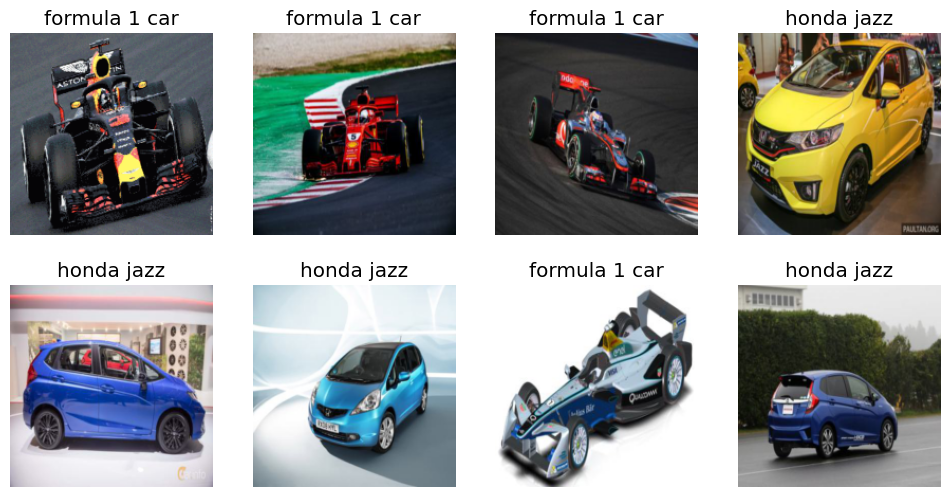

In [199]:
# create DataBlock and show batch
block = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.2),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)
dls = block.dataloaders(path)

dls.show_batch(max_n=8)

In [200]:
# train vision learner model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.815683,0.060097,0.024390,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.100029,0.049153,0.024390,00:01
1,0.055248,0.040734,0.012195,00:01
2,0.037924,0.046171,0.012195,00:01


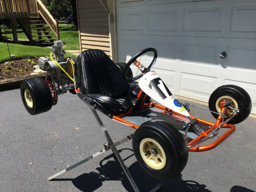

Cat: formula 1 car; Prob: 1.0000


In [201]:
# test model with inference on new image
term = 'blue honda jazz'
term = 'race kart'

def inference_new_image(term, display_result=True):
    image = download_single(term, show_image=False)
    # display(image.to_thumb(256,256))

    cat, cat_idx, probs = learn.predict(image)

    if display_result:
        display(image.to_thumb(256, 256))
        print(f'Cat: {cat}; Prob: {probs[cat_idx]:.4f}')

    return cat, cat_idx, probs

inference_new_image(term, display_result=True);

In [ ]:
# Random notes

'''
Radek Osmulski:
    The author of Meta Learning: How To Learn Deep Learning and Thrive In The Digital World

How to learn effectively:
    Mathematicians Lament: Paul Lockhart
    Making Learning Whole: David Perkins
'''

## Model 2: House vs Tractor

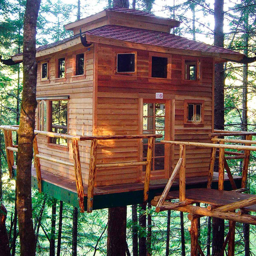

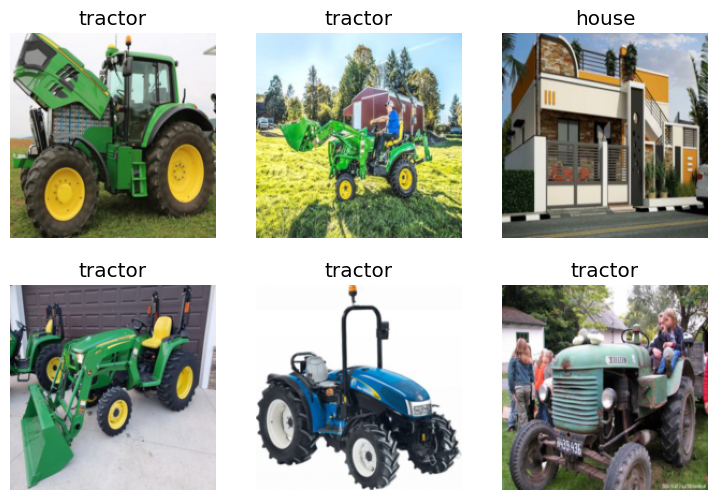

In [207]:
term = 'house'
image = download_single(term)

terms = ['house', 'tractor']
path = Path('house_or_tractor')
if not path.exists():
    for term in terms:
        dest = path/term
        dest.mkdir(exist_ok=True, parents=True)
        urls = search_images_ddg(term, max_images=200)
        download_images(dest, urls=urls[:])
        resize_images(dest, max_size=400, dest=dest)
    
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

block = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=[Resize(192, method='squish')]
)
dls = block.dataloaders(path)

dls.show_batch(max_n=6)

In [208]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.968507,0.133422,0.040000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.074190,0.100539,0.040000,00:01
1,0.053447,0.010181,0.000000,00:01
2,0.034458,0.005981,0.000000,00:01


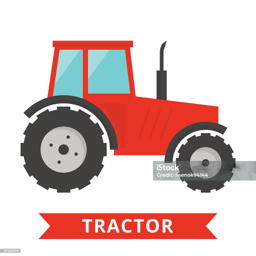

tractor
tensor(1)
tensor([8.5793e-06, 9.9999e-01])
99.9991%


In [213]:
term = 'red tractor'
dest = f'{term}.jpg'
url = search_images_ddg(term, max_images=1)
download_url(url[0], dest)
image = Image.open(dest)
display(image.to_thumb(256, 256))

cat, cat_idx, probs = learn.predict(dest)
print(cat)
print(cat_idx)
print(probs)
print(f'{probs[cat_idx]*100:.4f}%')

## Model 3: Dog vs Cat vs LLama

In [217]:
?download_single

Signature: download_single(term, show_image=True)
Docstring:
Download a single image based on a search term and optionally display it.

This function searches for an image using the specified search term, downloads the first image
found, and optionally displays a thumbnail of it. The image is saved locally.

Parameters:
    term (str): The search term to use for finding an image.
    show_image (bool, optional): A flag to determine whether to display the image. Defaults to True.

Returns:
    Image: An Image object of the downloaded image.
File:      /var/folders/55/3_yjz_1s37vcxh8ld7nlc8k00000gn/T/ipykernel_23359/1511666522.py
Type:      function

In [233]:
def download_single_image(term, dest, view=False):
    urls = search_images_ddg(term, max_images=1)
    download_url(urls[0], dest, show_progress=False)
    try:
        image = Image.open(dest)
        if view:
            display(image.to_thumb(256, 256))
    except Exception as e:
        print(f'error occured: {e}')

def download_dataset(terms, path, force=False,  max_images=200):
    if not path.exists() or force == True:
        for term in terms:
            dest = path/term
            dest.mkdir(exist_ok=True, parents=True)
            urls = search_images_ddg(term, max_images=max_images)
            download_images(dest, urls=urls[:])
            resize_images(dest, max_size=400, dest=path/term)
            print(f'{term} download complete')
    
    failed = verify_images(get_image_files(path))
    failed.map(Path.unlink)

term = 'cat'
dest = f'{term}.jpg'
# download_single_image(term, dest)

terms = ['cat', 'dog', 'llama']
path = Path('cat_dog_llama')
# download_dataset(terms, path)

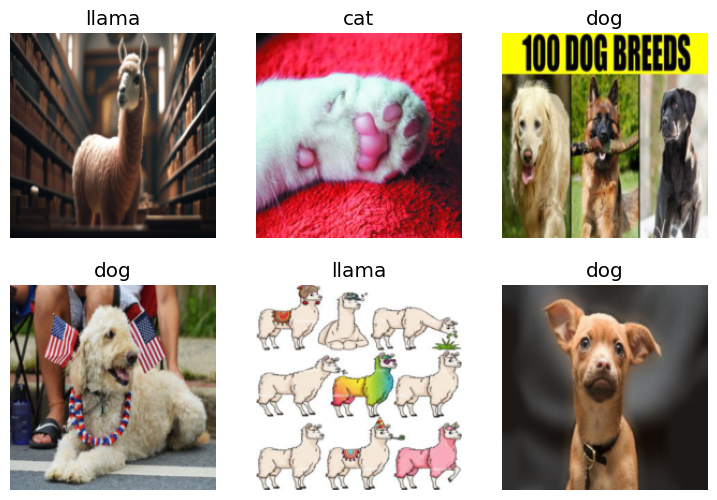

In [230]:
dataBlock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=[Resize(192, method='squish')]
)
dls = dataBlock.dataloaders(path)

dls.show_batch(max_n=6)

epoch,train_loss,valid_loss,error_rate,time
0,1.660565,0.614376,0.172840,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.592174,0.306481,0.123457,00:02
1,0.410518,0.286022,0.086420,00:02
2,0.306784,0.292725,0.098765,00:02


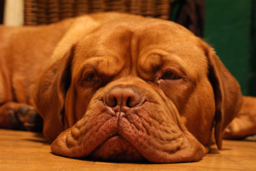

dog
98.7688%


In [231]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

term = 'orange dog'
dest = f'{term}.jpg'
download_single_image(term, dest, view=True)

cat, cat_idx, probs = learn.predict(dest)
print(cat)
print(f'{probs[cat_idx]*100:.4f}%')

# Moving On

"For those of you who don't know Python, you're biting into a big thing here" - Jeremy Howard at the end of lesson 1

"The most important thing to do it *experiment*"

### Homework
- Produce something like a trained model on a new dataset, maybe with > 2 categories
- Submit your work on the fastai forum
- Read chapter 1 of the book

# Model 4 : Fashion Era Detector

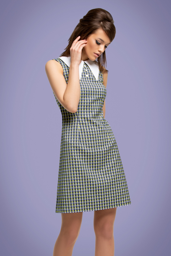

1960s fashion download complete
1970s fashion download complete
1980s fashion download complete
1990s fashion download complete
2000s fashion download complete
2010s fashion download complete


In [234]:
terms = [
    '1960s fashion',
    '1970s fashion',
    '1980s fashion',
    '1990s fashion',
    '2000s fashion',
    '2010s fashion'
    ]

image = download_single(terms[0])

path = Path('decades_fashion')
download_dataset(terms, path)

In [236]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

In [238]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)
                       

epoch,train_loss,valid_loss,error_rate,time
0,2.907100,1.878788,0.643564,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.681377,1.444892,0.490099,00:04
1,1.240275,1.443705,0.450495,00:04
2,0.943857,1.379701,0.430693,00:04


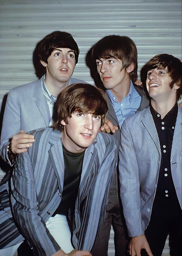

In [243]:
term = 'the beatles 1965'
dest = f'{term}.jpg'
download_single(term, dest);

In [254]:
cat, cat_idx, probs = learn.predict(dest)
print(cat)
print(f'{probs[cat_idx]*100:.2f}%')

all_indices = list(range(len(probs)))
print(all_indices)
sorted_indices = sorted(all_indices, key=lambda x: probs[x], reverse=True)
print(sorted_indices)

for idx in sorted_indices:
    print(f'Category: {cat[idx]}, Probability: {probs[idx]*100:.2f}%')

1980s fashion
54.06%
[0, 1, 2, 3, 4, 5]
[2, 3, 5, 4, 0, 1]
Category: 8, Probability: 54.06%
Category: 0, Probability: 30.80%
Category:  , Probability: 7.21%
Category: s, Probability: 6.37%
Category: 1, Probability: 1.53%
Category: 9, Probability: 0.03%


In [261]:
cat, cat_idx, probs = learn.predict(dest)
print(cat)
print(f'{probs[cat_idx]*100:.2f}%')

all_indices = list(range(len(probs)))
print(all_indices)
sorted_indices = sorted(all_indices, key=lambda x: probs[x], reverse=True)
print(sorted_indices)

for idx in sorted_indices:
    print(f'Category: {learn.dls.vocab[idx]}, Probability: {probs[idx]*100:.2f}%')

1980s fashion
54.06%
[0, 1, 2, 3, 4, 5]
[2, 3, 5, 4, 0, 1]
Category: 1980s fashion, Probability: 54.06%
Category: 1990s fashion, Probability: 30.80%
Category: 2010s fashion, Probability: 7.21%
Category: 2000s fashion, Probability: 6.37%
Category: 1960s fashion, Probability: 1.53%
Category: 1970s fashion, Probability: 0.03%


In [260]:
learn.dls.vocab

['1960s fashion', '1970s fashion', '1980s fashion', '1990s fashion', '2000s fashion', '2010s fashion']

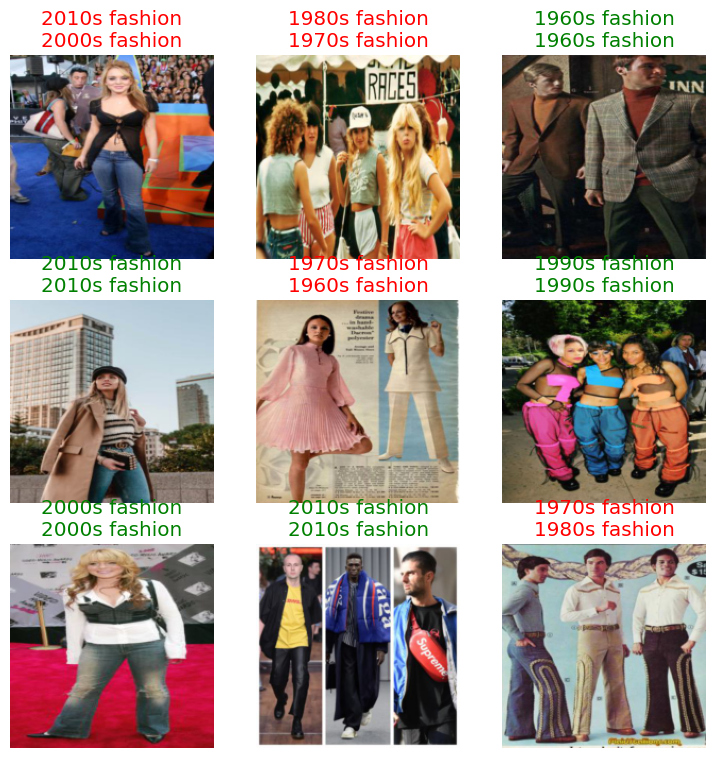

In [258]:
learn.show_results()